# Imports

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, make_scorer
import os

ImportError: cannot import name 'GridSearch' from 'sklearn.model_selection' (c:\Users\mamdaliof\anaconda3\envs\ML\lib\site-packages\sklearn\model_selection\__init__.py)

In [2]:
%cd D:\desk top folders\ML\MachineLearning2024W\Projects\mini project 2\Dataset

D:\desk top folders\ML\MachineLearning2024W\Projects\mini project 2\Dataset


In [ ]:
!gdown 1uNvtOnLKcJZ37KF1rgJKcfbdTznD7UWR

In [3]:
data = pd.read_csv("drug200.csv")
data.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


# Section1 

## Prepare Data

c:\Users\mamdaliof\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\mamdaliof\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  func(x=vector, **plot_kwargs)
c:\Users\mamdaliof\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  func(x=x, y=y, **kwargs)
c:\Users\mamdaliof\anaconda3\envs\ML\lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: The palette list has more values (9) than needed (5), which may not be intended.
  func(x=x, y=y, **kwargs)


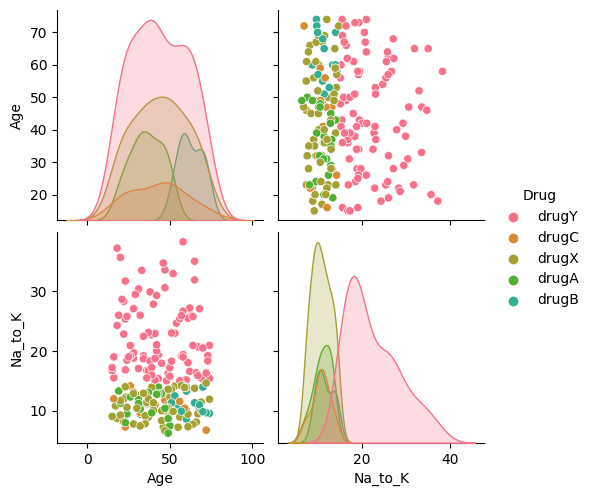

In [4]:
sns.pairplot(data=data, hue='Drug',palette=sns.color_palette("husl", 9))

In [5]:
# Feature selection (assuming the target column is named 'target')
X = data.drop('Drug', axis=1)
y = data['Drug']

# Encode categorical columns
le = LabelEncoder()
for column in X.columns:
    if X[column].dtype == 'object':
        X[column] = le.fit_transform(X[column])

# Split the data into training and testing sets (85% train, 15% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.85,stratify=y, random_state=53)
print(f'Train set: {X_train.shape}, {y_train.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')

Train set: (30, 5), (30,)
Test set: (170, 5), (170,)


## Train Model - Basic

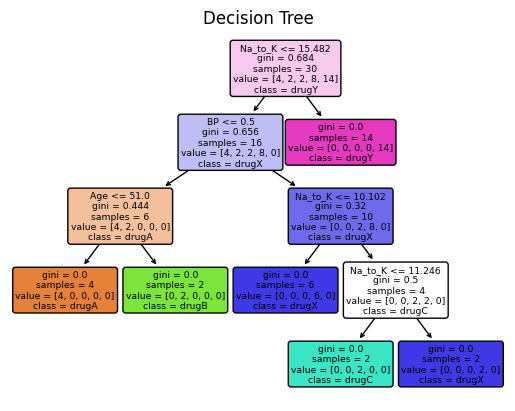

In [6]:
# Create a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=53)

# Train the classifier on the training data
clf.fit(X_train, y_train)

plot_tree(clf, filled=True, feature_names=X.columns, class_names=clf.classes_, rounded=True)
plt.title('Decision Tree')
plt.show()

### Inference

In [7]:
def show_metric(clf,x, y ):
    # Predict on the test set
    y_pred = clf.predict(x)

    # Evaluate the classifier
    class_report = classification_report(y, y_pred)

    ConfusionMatrixDisplay.from_predictions(y,y_pred, display_labels=clf.classes_,cmap=plt.cm.Blues, normalize= "true")
    ConfusionMatrixDisplay.from_predictions(y,y_pred, display_labels=clf.classes_,cmap=plt.cm.Blues,)
    print("\nClassification Report:\n", class_report)

train metrics:

Classification Report:
               precision    recall  f1-score   support

       drugA       1.00      1.00      1.00         4
       drugB       1.00      1.00      1.00         2
       drugC       1.00      1.00      1.00         2
       drugX       1.00      1.00      1.00         8
       drugY       1.00      1.00      1.00        14

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



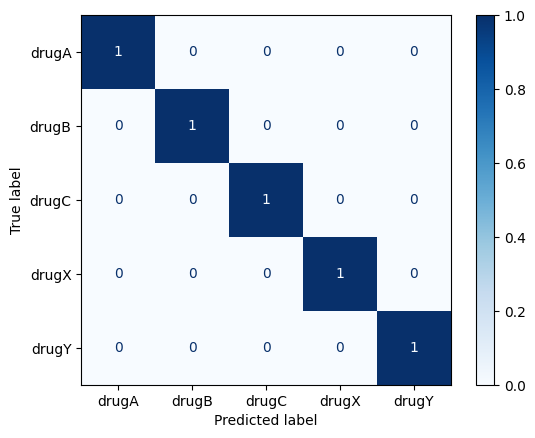

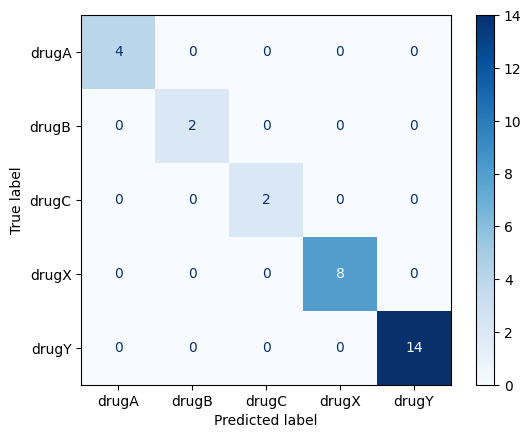

In [8]:
print("train metrics:")
show_metric(clf,X_train, y_train )

testain metrics:

Classification Report:
               precision    recall  f1-score   support

       drugA       0.90      1.00      0.95        19
       drugB       0.93      0.93      0.93        14
       drugC       0.30      0.21      0.25        14
       drugX       0.71      0.85      0.77        46
       drugY       1.00      0.91      0.95        77

    accuracy                           0.85       170
   macro avg       0.77      0.78      0.77       170
weighted avg       0.85      0.85      0.84       170



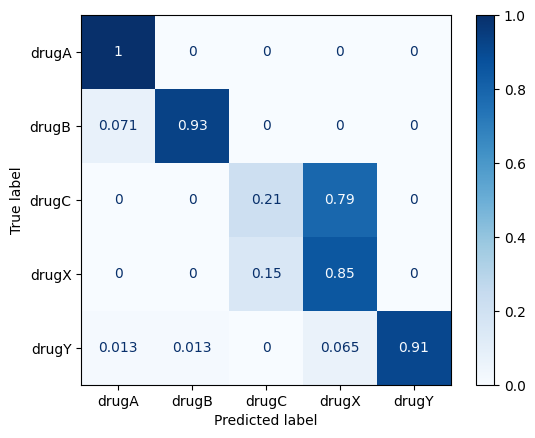

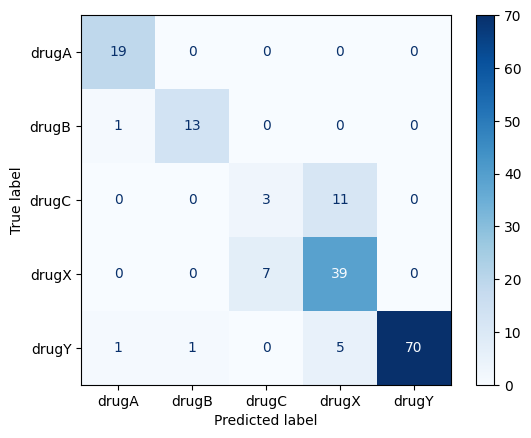

In [9]:
print("testain metrics:")
show_metric(clf,X_test, y_test )

## Train Model - pre-pruning

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
param_grid = {
    'max_depth': [2, 3, None],
    'min_samples_split':  [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4]
}
scoring = {
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro')
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid,
                           scoring=scoring, refit='precision', return_train_score=True)
grid_search.fit(X_train, y_train)

# Print the best parameters and the best scores
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_:.2f}')


# Extract results from grid search
results = grid_search.cv_results_

Best Parameters: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score: 0.69


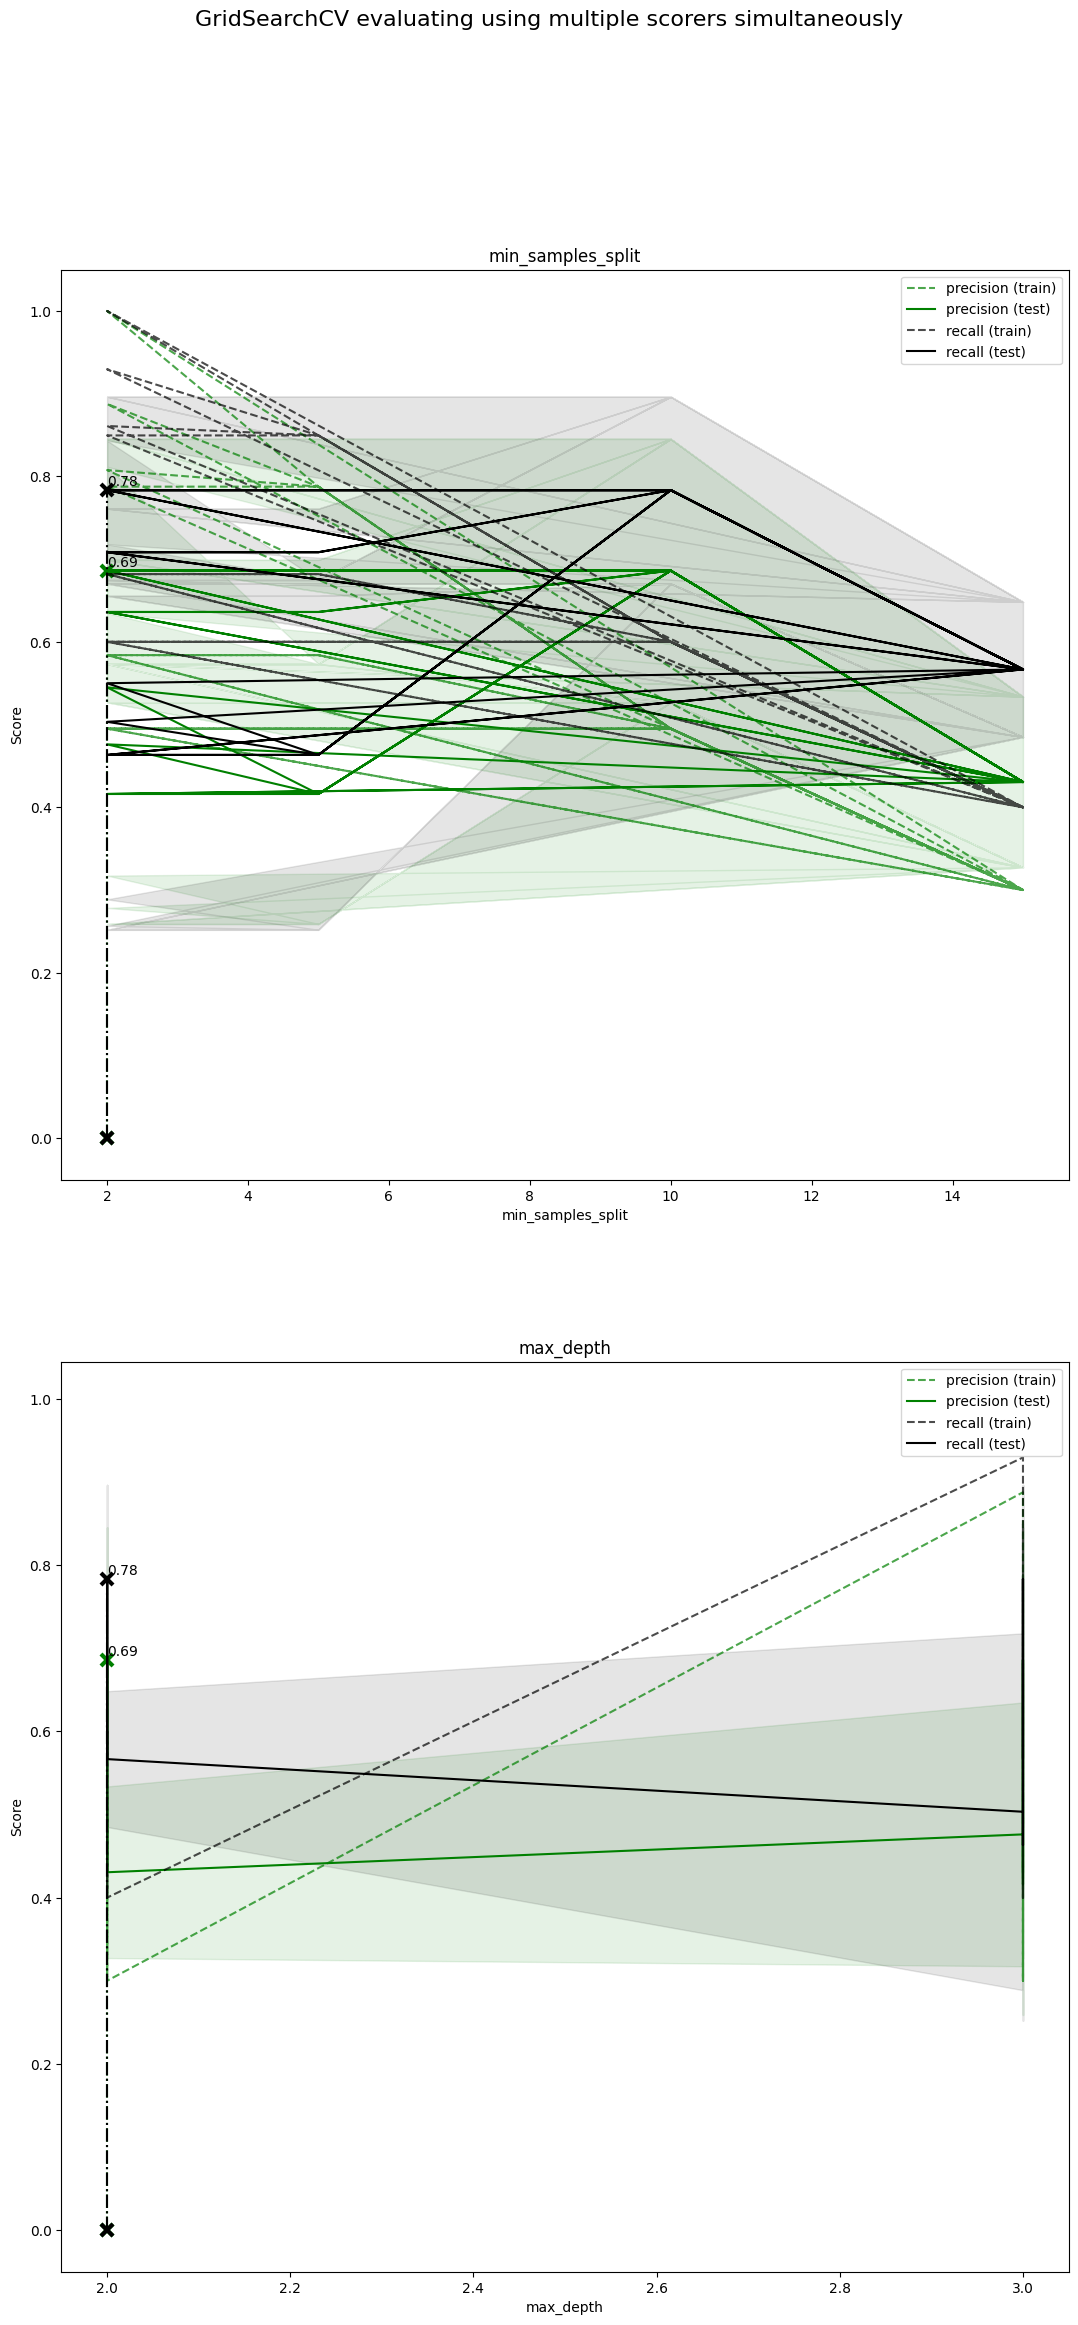

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(13, 26))
fig.suptitle("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

# Plot for min_samples_split
ax = axes[0]
ax.set_title("min_samples_split")
ax.set_xlabel("min_samples_split")
ax.set_ylabel("Score")

X_axis = np.array(results["param_min_samples_split"].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results[f"mean_{sample}_{scorer}"]
        sample_score_std = results[f"std_{sample}_{scorer}"]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label=f"{scorer} ({sample})",
        )

    best_index = np.nonzero(results[f"rank_test_{scorer}"] == 1)[0][0]
    best_score = results[f"mean_test_{scorer}"][best_index]

    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    ax.annotate(f"{best_score:.2f}", (X_axis[best_index], best_score + 0.005))

ax.legend(loc="best")
ax.grid(False)

# Plot for max_depth
ax = axes[1]
ax.set_title("max_depth")
ax.set_xlabel("max_depth")
ax.set_ylabel("Score")

X_axis = np.array(results["param_max_depth"].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results[f"mean_{sample}_{scorer}"]
        sample_score_std = results[f"std_{sample}_{scorer}"]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label=f"{scorer} ({sample})",
        )

    best_index = np.nonzero(results[f"rank_test_{scorer}"] == 1)[0][0]
    best_score = results[f"mean_test_{scorer}"][best_index]

    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    ax.annotate(f"{best_score:.2f}", (X_axis[best_index], best_score + 0.005))

ax.legend(loc="best")
ax.grid(False)

plt.show()

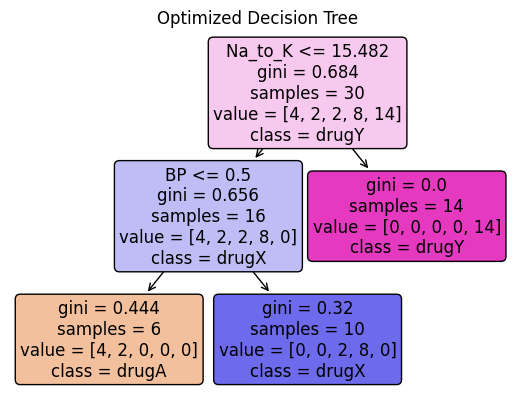

In [17]:
clf = grid_search.best_estimator_
clf.fit(X_train, y_train)

# Plot the Decision Tree
plot_tree(clf, filled=True, feature_names=X.columns, class_names=clf.classes_, rounded=True)
plt.title('Optimized Decision Tree')
plt.show()



### Inference

train metrics:

Classification Report:
               precision    recall  f1-score   support

       drugA       0.67      1.00      0.80         4
       drugB       0.00      0.00      0.00         2
       drugC       0.00      0.00      0.00         2
       drugX       0.80      1.00      0.89         8
       drugY       1.00      1.00      1.00        14

    accuracy                           0.87        30
   macro avg       0.49      0.60      0.54        30
weighted avg       0.77      0.87      0.81        30



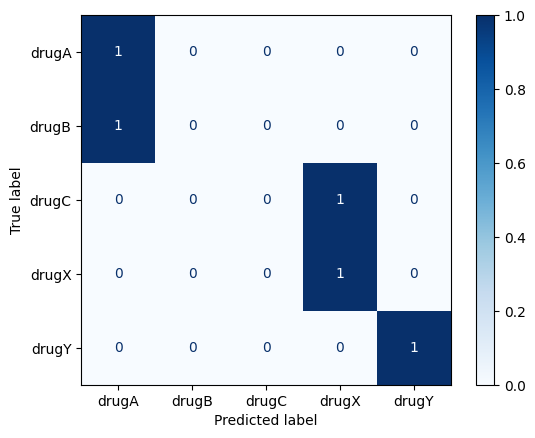

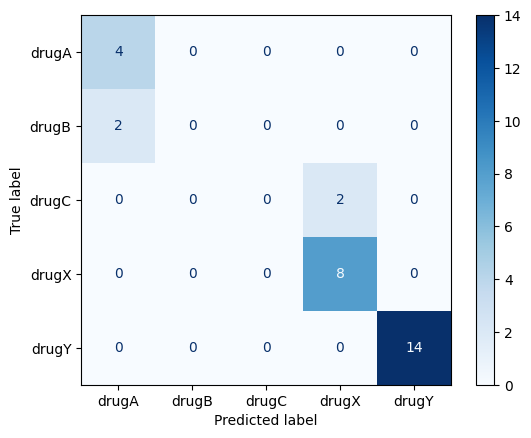

In [18]:
print("train metrics:")
show_metric(clf,X_train, y_train )

test metrics:

Classification Report:
               precision    recall  f1-score   support

       drugA       0.54      1.00      0.70        19
       drugB       0.00      0.00      0.00        14
       drugC       0.00      0.00      0.00        14
       drugX       0.71      1.00      0.83        46
       drugY       1.00      0.91      0.95        77

    accuracy                           0.79       170
   macro avg       0.45      0.58      0.50       170
weighted avg       0.71      0.79      0.73       170



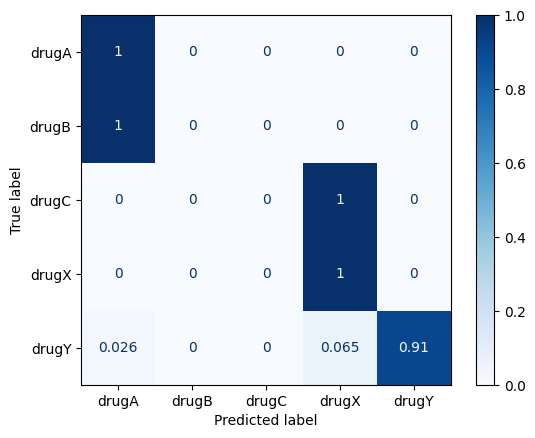

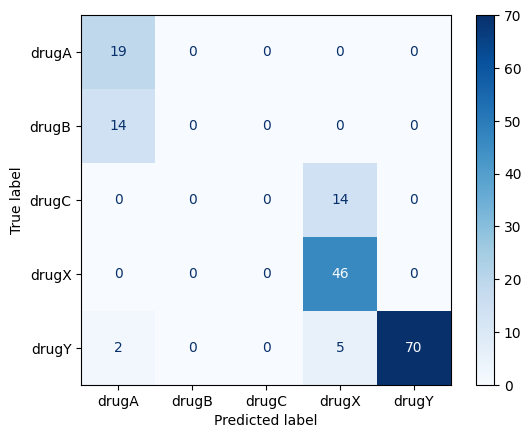

In [19]:
print("test metrics:")
show_metric(clf,X_test, y_test )

## Train Model - post-pruning

In [20]:
clf = DecisionTreeClassifier(random_state=53)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=53, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.33444444444444443


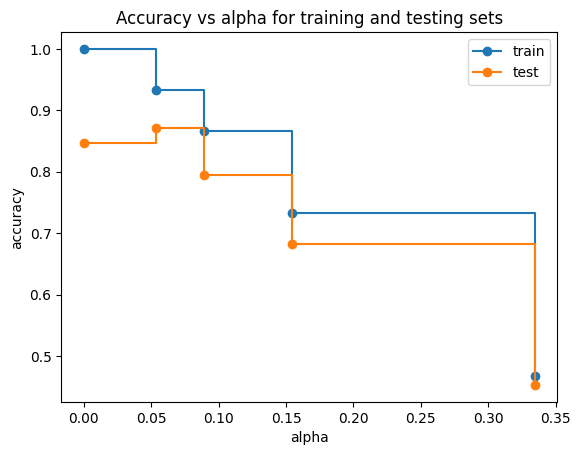

In [22]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [23]:
clf = DecisionTreeClassifier(random_state=53, ccp_alpha=ccp_alphas[1])
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.05333333333333332, random_state=53)

### Inference

train metrics:

Classification Report:
               precision    recall  f1-score   support

       drugA       1.00      1.00      1.00         4
       drugB       1.00      1.00      1.00         2
       drugC       0.00      0.00      0.00         2
       drugX       0.80      1.00      0.89         8
       drugY       1.00      1.00      1.00        14

    accuracy                           0.93        30
   macro avg       0.76      0.80      0.78        30
weighted avg       0.88      0.93      0.90        30



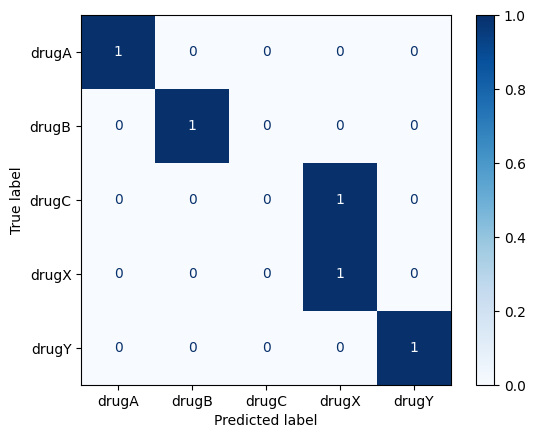

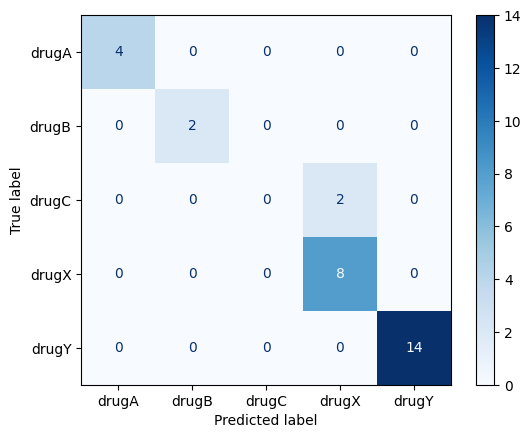

In [24]:
print("train metrics:")
show_metric(clf,X_train, y_train )

test metrics:

Classification Report:
               precision    recall  f1-score   support

       drugA       0.90      1.00      0.95        19
       drugB       0.93      0.93      0.93        14
       drugC       0.00      0.00      0.00        14
       drugX       0.71      1.00      0.83        46
       drugY       1.00      0.91      0.95        77

    accuracy                           0.87       170
   macro avg       0.71      0.77      0.73       170
weighted avg       0.82      0.87      0.84       170



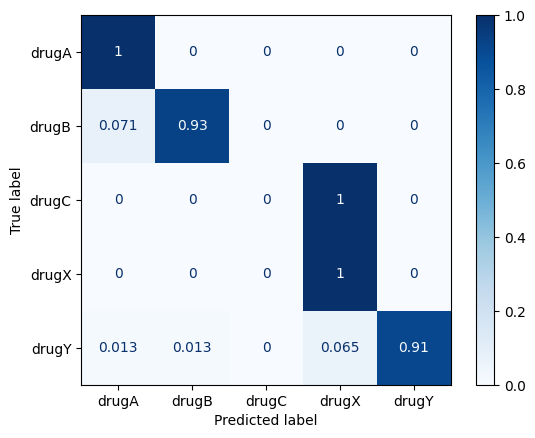

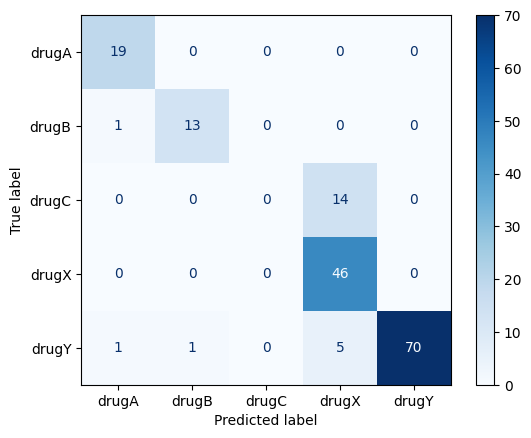

In [25]:
print("test metrics:")
show_metric(clf,X_test, y_test )

## Random forest and AdaBoost

In [32]:
# Define the parameter grid for the Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [4, 6, 8, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest classifier
rf_clf = RandomForestClassifier(random_state=53)

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_clf, param_grid=param_grid_rf, cv=5, n_jobs=-1, )

# Fit GridSearchCV
grid_search_rf.fit(X_train, y_train)

# Best parameters and best score
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print("Best parameters for Random Forest:", best_params_rf)
print("Best cross-validation score for Random Forest:", best_score_rf)

# Evaluate the best estimator on the test set
rf_clf = grid_search_rf.best_estimator_

Best parameters for Random Forest: {'bootstrap': False, 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score for Random Forest: 0.9333333333333333


train metrics:

Classification Report:
               precision    recall  f1-score   support

       drugA       1.00      1.00      1.00         4
       drugB       1.00      1.00      1.00         2
       drugC       1.00      1.00      1.00         2
       drugX       1.00      1.00      1.00         8
       drugY       1.00      1.00      1.00        14

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



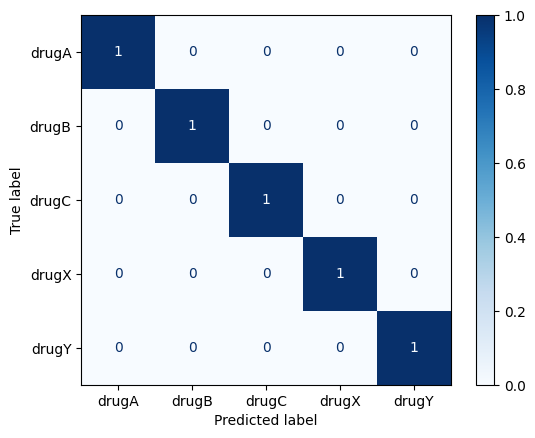

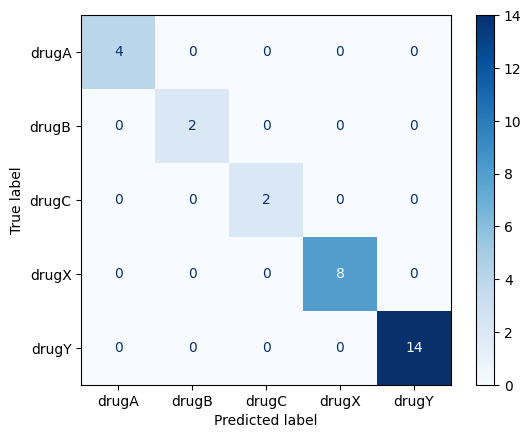

In [33]:
print("train metrics:")
show_metric(rf_clf,X_train, y_train )

test metrics:

Classification Report:
               precision    recall  f1-score   support

       drugA       0.70      1.00      0.83        19
       drugB       0.80      0.29      0.42        14
       drugC       0.70      0.50      0.58        14
       drugX       0.80      0.98      0.88        46
       drugY       1.00      0.94      0.97        77

    accuracy                           0.86       170
   macro avg       0.80      0.74      0.74       170
weighted avg       0.87      0.86      0.85       170



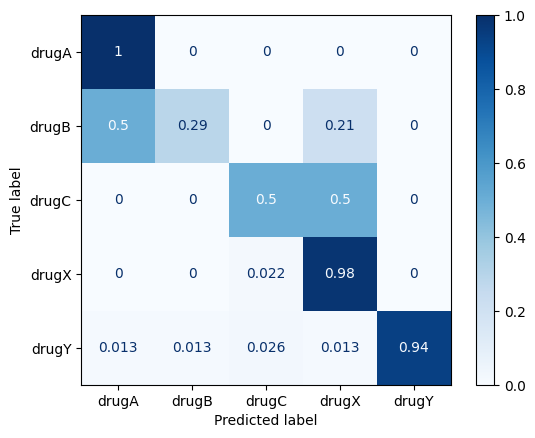

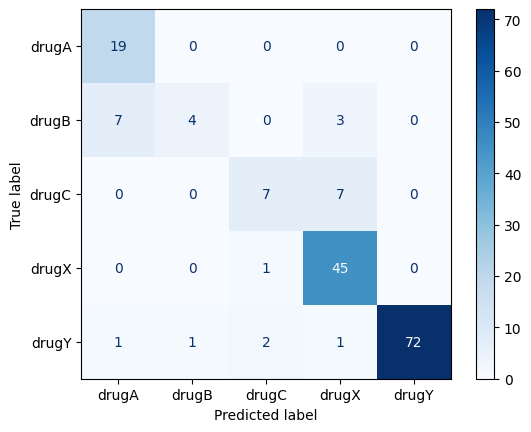

In [34]:
print("test metrics:")
show_metric(rf_clf,X_test, y_test )